## Please select parameters below

In [2]:
# True if run a certain part of analysis (NN training), False otherwise
_RETRAIN_CNNs = True
_RETRAIN_ResNNs = True
_RETRAIN_RecNNs = True

## Installing packages

We will start by installing required packages. If we use Google Colab we just need to install [biopython](https://biopython.org).

In [ ]:
# To write bash code in python jupyter cell, put ! before the command
!pip install biopython
!pip install tensorflow-addons
!pip install gdown

## Loading the data

Let us clone the Github repository of [Zhang et al.](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-020-03864-0) to access the [data](https://github.com/yuuuuzhang/TriplexFPP_data) and the [code](https://github.com/yuuuuzhang/TriplexFPP).

In [ ]:
!git clone https://github.com/yuuuuzhang/TriplexFPP_data.git  # downloading data
!git clone https://github.com/yuuuuzhang/TriplexFPP.git  # downloading code

fatal: destination path 'TriplexFPP_data' already exists and is not an empty directory.
fatal: destination path 'TriplexFPP' already exists and is not an empty directory.


Checking if all the needed files are in the working folder.

In [ ]:
import os

if not os.path.exists('./processed_data.zip'):
    raise FileNotFoundError('Please put processed_data.zip in the same folder as the jupyter notebook')

!unzip "./processed_data.zip"  # unzip processed_data.zip

# Creating a folder for saved figures and models
!mkdir -p figs
!mkdir -p models

Importing different models used in the notebooks (mainly Tensorflow and Keras).

In [ ]:
import multiprocessing
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import math
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import losses, optimizers, metrics, layers, models, callbacks
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

from Bio import SeqIO

%matplotlib inline

Now we can load the data from [repository](https://github.com/yuuuuzhang/TriplexFPP_data).

In [ ]:
# Defining the paths to input files
lncRNA_neg = './TriplexFPP_data/data/triplexlncRNA_neg.fa'
lncRNA_pos = './TriplexFPP_data/data/triplexlncRNA_pos.fa'
DNA_neg = './TriplexFPP_data/data/triplexDNA_neg.fa'
DNA_pos = './TriplexFPP_data/data/triplexDNA_pos.fa'

lncRNA_neg_records = list(SeqIO.parse(lncRNA_neg, "fasta"))
lncRNA_pos_records = list(SeqIO.parse(lncRNA_pos, "fasta"))
DNA_neg_records = list(SeqIO.parse(DNA_neg, "fasta"))
DNA_pos_records = list(SeqIO.parse(DNA_pos, "fasta"))

print(f'Overall we have:'
      f'\n{len(lncRNA_neg_records)} lncRNA triplex negative entries'
      f'\n{len(lncRNA_pos_records)} lncRNA triplex positive entries'
      f'\n{len(DNA_neg_records)} DNA triplex negative entries'
      f'\n{len(DNA_pos_records)} DNA triplex positive entries')

Overall we have:
36022 lncRNA triplex negative entries
531 lncRNA triplex positive entries
12735 DNA triplex negative entries
2547 DNA triplex positive entries


Now let us have a look at the data that we just loaded..

In [ ]:
# plotting lncRNA and DNA length distributions, getting some statistics
DNA_lengths = [len(record.seq) for record in DNA_neg_records + DNA_pos_records]
lncRNA_lengths = [len(record.seq) for record in lncRNA_neg_records + lncRNA_pos_records]
print(f'The median length of DNA samples: {np.median(DNA_lengths)}. The median length of lncRNA samples: {np.median(lncRNA_lengths)}.')
print(f'The STD of lncRNA length: {np.std(lncRNA_lengths):.2f}. The STD for DNA length: {np.std(DNA_lengths):.2f}.')
print(f'The range for lncRNA length: {(np.min(lncRNA_lengths), np.max(lncRNA_lengths))}. The range for DNA length: {(np.min(DNA_lengths), np.max(DNA_lengths))}.')

The median length of DNA samples: 601.0. The median length of lncRNA samples: 1181.0.
The STD of lncRNA length: 1750.41. The STD for DNA length: 413.11.
The range for lncRNA length: (79, 205012). The range for DNA length: (151, 3851).


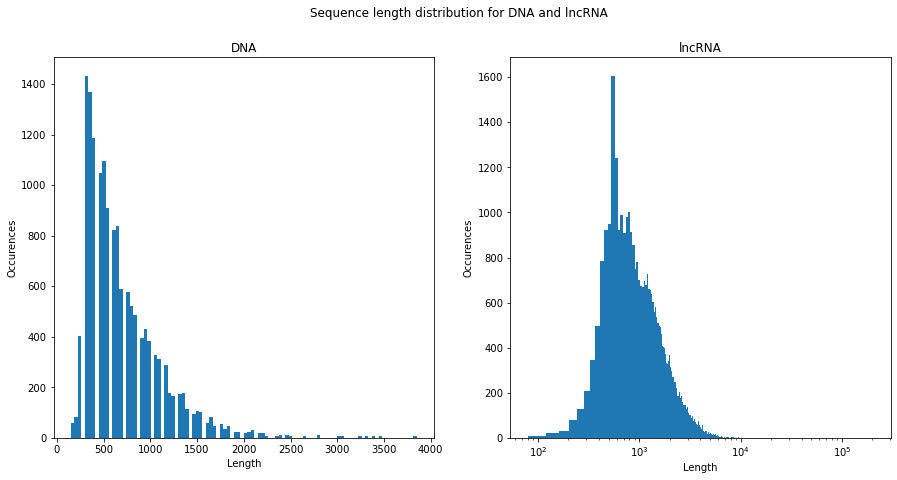

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(15,7))
ax[0].hist(DNA_lengths, bins=100)
ax[0].set_xlabel('Length')
ax[0].set_ylabel('Occurences')
ax[0].set_title('DNA')
ax[1].hist(lncRNA_lengths, bins=5000)
ax[1].set_xlabel('Length')
ax[1].set_ylabel('Occurences')
ax[1].set_title('lncRNA')
ax[1].set_xscale('log')
f.suptitle('Sequence length distribution for DNA and lncRNA')
plt.savefig('./figs/seq_len_dist.png', dpi=300)

In [ ]:
lncRNA_neg_records[:2]

[SeqRecord(seq=Seq('GTGCACACGGCTCCCATGCGTTGTCTTCCGAGCGTCAGGCCGCCCCTACCCGTG...TAT'), id='ENST00000473358.1|ENSG00000243485.5|OTTHUMG00000000959.2|OTTHUMT00000002840.1|MIR1302-2HG-202|MIR1302-2HG|712|', name='ENST00000473358.1|ENSG00000243485.5|OTTHUMG00000000959.2|OTTHUMT00000002840.1|MIR1302-2HG-202|MIR1302-2HG|712|', description='ENST00000473358.1|ENSG00000243485.5|OTTHUMG00000000959.2|OTTHUMT00000002840.1|MIR1302-2HG-202|MIR1302-2HG|712|', dbxrefs=[]),
 SeqRecord(seq=Seq('TCATCAGTCCAAAGTCCAGCAGTTGTCCCTCCTGGAATCCGTTGGCTTGCCTCC...GTC'), id='ENST00000469289.1|ENSG00000243485.5|OTTHUMG00000000959.2|OTTHUMT00000002841.2|MIR1302-2HG-201|MIR1302-2HG|535|', name='ENST00000469289.1|ENSG00000243485.5|OTTHUMG00000000959.2|OTTHUMT00000002841.2|MIR1302-2HG-201|MIR1302-2HG|535|', description='ENST00000469289.1|ENSG00000243485.5|OTTHUMG00000000959.2|OTTHUMT00000002841.2|MIR1302-2HG-201|MIR1302-2HG|535|', dbxrefs=[])]

In [ ]:
lncRNA_pos_records[:2]

[SeqRecord(seq=Seq('GCAGCGCCCCACTCAACAAAGCTTCCCGCGGGCCCTGCCCCATGACTCACCGCT...TTC'), id='ENST00000609111.1|ENSG00000272734.1|OTTHUMG00000185998.2|OTTHUMT00000471963.1|ADIRF-AS1-203|ADIRF-AS1|3822|', name='ENST00000609111.1|ENSG00000272734.1|OTTHUMG00000185998.2|OTTHUMT00000471963.1|ADIRF-AS1-203|ADIRF-AS1|3822|', description='ENST00000609111.1|ENSG00000272734.1|OTTHUMG00000185998.2|OTTHUMT00000471963.1|ADIRF-AS1-203|ADIRF-AS1|3822|', dbxrefs=[]),
 SeqRecord(seq=Seq('AAGAGACAGCGCCGCCGGCCGTGGGGAGCGGACGCAGTGATTTGCTCCCCCTCG...ATG'), id='ENST00000574016.5|ENSG00000186594.14|OTTHUMG00000132197.7|OTTHUMT00000438379.2|MIR22HG-207|MIR22HG|557|', name='ENST00000574016.5|ENSG00000186594.14|OTTHUMG00000132197.7|OTTHUMT00000438379.2|MIR22HG-207|MIR22HG|557|', description='ENST00000574016.5|ENSG00000186594.14|OTTHUMG00000132197.7|OTTHUMT00000438379.2|MIR22HG-207|MIR22HG|557|', dbxrefs=[])]

In [ ]:
DNA_neg_records[:2]

[SeqRecord(seq=Seq('CTCCTTCGTGGCGAAGCAGCAGGTGGAGAAGCAGCGGCCCCTGCGCTGCCTCAT...TAT'), id='chromosome:GRCh38:1:148262868:148263318:-1', name='chromosome:GRCh38:1:148262868:148263318:-1', description='chromosome:GRCh38:1:148262868:148263318:-1', dbxrefs=[]),
 SeqRecord(seq=Seq('CCCTGGGGACACAGGCGCGGGGGAGGGGAGCGCGGCCCGCGCGGGGCAGGAGGT...GCG'), id='chromosome:GRCh38:3:32238750:32238900:-1', name='chromosome:GRCh38:3:32238750:32238900:-1', description='chromosome:GRCh38:3:32238750:32238900:-1', dbxrefs=[])]

In [ ]:
DNA_pos_records[:2]

[SeqRecord(seq=Seq('TTAAGAATGGTTATGTTAGGGTTGTACGGTAGAACTGCTGTTATTCATCCTATG...CTT'), id='chromosome:GRCh38:1:629800:630250:-1', name='chromosome:GRCh38:1:629800:630250:-1', description='chromosome:GRCh38:1:629800:630250:-1', dbxrefs=[]),
 SeqRecord(seq=Seq('GGAGGGGCGGCAGGTGGTGAGTCTCGACCCCGCACTGGGCTGGCAGGGCCGAGG...GGA'), id='chromosome:GRCh38:1:1312900:1313050:-1', name='chromosome:GRCh38:1:1312900:1313050:-1', description='chromosome:GRCh38:1:1312900:1313050:-1', dbxrefs=[])]

Now let us prepare the data as it is described in the [Zhang et al.](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-020-03864-0#MOESM1). We will use a simplified preprocessing, where we will enrich the positive data by oversampling and deplete negative data by undersampling. We will fix the data size for lncRNA triplex as `lncRNA_samples = 1500` (3 times bigger than the size of positive samples), while the data size for DNA triplex is `DNA_samples = 6000` (2.4 times bigger than the size of positive samples). Let us start by denoting some supplementary functions that we will use to extract sequence features used for training/testing.

In [ ]:
# Setting plotting parameters
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


def get_seq_name_from_records(records):
    # This function is used to extract nuclotide sequence and its id
    seq = []
    name = []
    for i in range(len(records)):
        seq.append(records[i].seq)
        name.append(records[i].id)

    return seq, name

def extract_features(seq, lbls, train_percentage):
    # This function extracts kmers and kmerscores from the sequence data

    kmer1 = kmer_encode(seq, kmerArray[0:4])
    kmer2 = kmer_encode(seq, kmerArray[4:20])
    kmer3 = kmer_encode(seq, kmerArray[20:84])

    # Extracting only train data to compute mean k-mer vectors
    seq_train, lbls_train = seq[:int(train_percentage*len(seq))], lbls[:int(train_percentage*len(lbls))]

    pos_seq = seq_train[lbls_train == 1]
    neg_seq = seq_train[lbls_train == 0]

    pos_kmers = kmer_encode(pos_seq, kmerArray)
    neg_kmers = kmer_encode(neg_seq, kmerArray)

    pos = np.mean(pos_kmers, axis=0)
    neg = np.mean(neg_kmers, axis=0)

    merscore1 = mer_score(seq, pos[0:4], neg[0:4], kmerArray[0:4],1)
    merscore2 = mer_score(seq, pos[4:20], neg[4:20], kmerArray[4:20],2)
    merscore3 = mer_score(seq, pos[20:84], neg[20:84], kmerArray[20:84],3)
    merscore4 = mer_score(seq, pos[84:340], neg[84:340], kmerArray[84:340],4)
    merscore5 = mer_score(seq, pos[340:1364], neg[340:1364], kmerArray[340:1364],5)
    merscore6 = mer_score(seq, pos[1364:5460], neg[1364:5460], kmerArray[1364:5460],6)

    features = np.concatenate((merscore1,merscore2,merscore3,merscore4,merscore5,merscore6,kmer1,kmer2,kmer3),axis=1)

    return features

def plot_metrics(history, model_name):
    # Courtesy of https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#oversample_the_minority_class
    metrics = ['loss', 'auc', 'precision', 'recall', 'f1_score', 'mcc']
    fig = plt.figure(figsize=(20,7))
    for n, metric in enumerate(metrics):
        if metrics == 'f1_score':
            curr_train_history = np.transpose(np.array(history.history[metric]))[0]
            curr_val_history = np.transpose(np.array(history.history['val_'+metric]))[0]
        else:
            curr_train_history = np.array(history.history[metric])
            curr_val_history = np.array(history.history['val_'+metric])
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2, 3, n+1)
        plt.plot(history.epoch, curr_train_history, color=colors[0], label='Train')
        plt.plot(history.epoch, curr_val_history,
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        filtered_train_history = curr_train_history[~np.isnan(curr_train_history)]
        filtered_val_history = curr_val_history[~np.isnan(curr_val_history)]
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([max(max(filtered_train_history, default=0) - 0.5, 0), 1])

        plt.legend()

    plt.savefig(f'./figs/training_{model_name}.png', dpi=300)

#####
## The functions below were taken from TriplexFPP/code/triplex_util.py file
#####

def countnum(seq,nuacid):
    # This function counts number of nucleotid occurences in the sequence
    return len([1 for i in range(len(seq)) if seq.startswith(nuacid,i)])

def construct_kmer():
    # This function creates a list containing all possible k-mers (1 <= k <= 6)
	ntarr = ("A","C","G","T")

	kmerArray = []


	for n in range(4):
		kmerArray.append(ntarr[n])

	for n in range(4):
		str1 = ntarr[n]
		for m in range(4):
			str2 = str1 + ntarr[m]
			kmerArray.append(str2)
#############################################
	for n in range(4):
		str1 = ntarr[n]
		for m in range(4):
			str2 = str1 + ntarr[m]
			for x in range(4):
				str3 = str2 + ntarr[x]
				kmerArray.append(str3)
#############################################
#change this part for 3mer or 4mer
	for n in range(4):
		str1 = ntarr[n]
		for m in range(4):
			str2 = str1 + ntarr[m]
			for x in range(4):
				str3 = str2 + ntarr[x]
				for y in range(4):
					str4 = str3 + ntarr[y]
					kmerArray.append(str4)
############################################
	for n in range(4):
		str1 = ntarr[n]
		for m in range(4):
			str2 = str1 + ntarr[m]
			for x in range(4):
				str3 = str2 + ntarr[x]
				for y in range(4):
					str4 = str3 + ntarr[y]
					for z in range(4):
						str5 = str4 + ntarr[z]
						kmerArray.append(str5)
####################### 6-mer ##############
	for n in range(4):
		str1 = ntarr[n]
		for m in range(4):
			str2 = str1 + ntarr[m]
			for x in range(4):
				str3 = str2 + ntarr[x]
				for y in range(4):
					str4 = str3 + ntarr[y]
					for z in range(4):
						str5 = str4 + ntarr[z]
						for t in range(4):
							str6 = str5 + ntarr[t]
							kmerArray.append(str6)
    
	return kmerArray

def kmer_encode(seq,kmerarray):
    # This function computes k-mer feature from the sequence
    result = np.zeros((len(seq),len(kmerarray)))
    for i in range(len(seq)):
        for j in range(len(kmerarray)):
            result[i,j] = seq[i].count(kmerarray[j])/len(seq[i])
    return result

def mer_sin(seq,nc_m,c_m,kmerarray,x):   
    # This function computes coefficient in the kmerscore
    l = len(seq)-x+1
    log_r = np.zeros((l))
    for i in range(l):
        tempseq = seq[i:i+x]
        idx = kmerarray.index(tempseq)
        Fc = c_m[int(idx)]
        Fnc = nc_m[int(idx)]
        if Fc==0 and Fnc==0:
            log_r[i]=0
        elif Fc==0 and Fnc!=0:
            log_r[i]=-1
        elif Fnc==0 and Fc!=0:
            log_r[i]=1
        else:
            log_r[i] = math.log(Fc/Fnc)
    miu = sum(log_r)/l
    
    return miu
   
def mer_score(seq,nc_m,c_m,kmerarray,x):
    # This function computes kmerscore from the sequence and mean kmers
    num_cores = multiprocessing.cpu_count()
    miu = Parallel(n_jobs=num_cores)(delayed(mer_sin)(seq_i, nc_m_i, c_m_i, kmerarray_i, x_i) for seq_i, nc_m_i, c_m_i, kmerarray_i, x_i in tqdm(zip(seq, [nc_m]*len(seq), [c_m]*len(seq), [kmerarray]*len(seq), [x]*len(seq)), desc=f'Computing {x}merscore'))
        
    miu0 = np.expand_dims(miu, axis=1)
    return miu0

In [ ]:
# Defining some constant hyperparameters
_DATA_SIZE_lncRNA = 3000
_DATA_SIZE_DNA = 12000
_TRAIN_PERCENTAGE = 0.8
_VAL_PERCENTAGE = 0.1
_TEST_PERCENTAGE = 0.1

_RELOAD_DATA = False

# Setting numpy random seed for reproducibility
np.random.seed(42)

# Getting a list of all possible k-mers from k = 1, to k = 6
kmerArray = construct_kmer()

if _RELOAD_DATA:

    # Dropping DNA sequences with letter 'N'
    DNA_neg_records = [record for record in DNA_neg_records if 'N' not in record.seq]
    DNA_pos_records = [record for record in DNA_pos_records if 'N' not in record.seq]

    # Extracting only sequences and names from lncRNA and DNA records
    lncRNA_neg_seq, lncRNA_neg_name = get_seq_name_from_records(lncRNA_neg_records)
    lncRNA_pos_seq, lncRNA_pos_name  = get_seq_name_from_records(lncRNA_pos_records)
    DNA_neg_seq, DNA_neg_name = get_seq_name_from_records(DNA_neg_records)
    DNA_pos_seq, DNA_pos_name = get_seq_name_from_records(DNA_pos_records)

    # Oversampling positive data and undersampling negative data
    lncRNA_neg_seq_balanced = resample(lncRNA_neg_seq, n_samples=_DATA_SIZE_lncRNA // 2)
    lncRNA_pos_seq_balanced = resample(lncRNA_pos_seq, n_samples=_DATA_SIZE_lncRNA // 2)
    DNA_neg_seq_balanced = resample(DNA_neg_seq, n_samples=_DATA_SIZE_DNA // 2)
    DNA_pos_seq_balanced = resample(DNA_pos_seq, n_samples=_DATA_SIZE_DNA // 2)

    # Merging positive and negative data, creating label array
    lncRNA_seq = np.array(lncRNA_neg_seq_balanced + lncRNA_pos_seq_balanced, dtype=object)
    DNA_seq = np.array(DNA_neg_seq_balanced + DNA_pos_seq_balanced, dtype=object)
    lncRNA_labels = np.array([0]*(_DATA_SIZE_lncRNA // 2) + [1]*(_DATA_SIZE_lncRNA // 2))
    DNA_labels = np.array([0]*(_DATA_SIZE_DNA // 2) + [1]*(_DATA_SIZE_DNA // 2))

    # Shuffling and saving data
    if not os.path.exists('./processed_data'):
        os.mkdir('processed_data')
        
    lncRNA_index = np.arange(_DATA_SIZE_lncRNA)
    np.random.shuffle(lncRNA_index)
    lncRNA_seq, lncRNA_labels = lncRNA_seq[lncRNA_index], lncRNA_labels[lncRNA_index]
    np.save('./lncRNA_sequences', lncRNA_seq)
    np.save('./lncRNA_labels', lncRNA_labels)

    DNA_index = np.arange(_DATA_SIZE_DNA)
    np.random.shuffle(DNA_index)
    DNA_seq, DNA_labels = DNA_seq[DNA_index], DNA_labels[DNA_index]
    np.save('./DNA_sequences', DNA_seq)
    np.save('./DNA_labels', DNA_labels)

## Preparing data, extracting features for model input

In [ ]:
if _RELOAD_DATA:
    # Extracting features for lncRNA data
    lncRNA_features = extract_features(lncRNA_seq, lncRNA_labels, _TRAIN_PERCENTAGE)
    np.save('./lncRNA_features', lncRNA_features)

In [ ]:
if _RELOAD_DATA:
    # Extracting features for DNA data
    DNA_features = extract_features(DNA_seq, DNA_labels, _TRAIN_PERCENTAGE)
    np.save('./DNA_features', DNA_features)

## Preparing data for training - scaling and splitting

We successfully extracted k-mer and kmerscore features from available list of sequences. Now let us prepare the data for training.

In [ ]:
# Setting constant hyperparameters
_lncRNA_TRAIN_SIZE = int(_TRAIN_PERCENTAGE * _DATA_SIZE_lncRNA)
_lncRNA_VAL_SIZE = int(_VAL_PERCENTAGE * _DATA_SIZE_lncRNA)
_lncRNA_TEST_SIZE = int(_TEST_PERCENTAGE * _DATA_SIZE_lncRNA)
_DNA_TRAIN_SIZE = int(_TRAIN_PERCENTAGE * _DATA_SIZE_DNA)
_DNA_VAL_SIZE = int(_VAL_PERCENTAGE * _DATA_SIZE_DNA)
_DNA_TEST_SIZE = int(_TEST_PERCENTAGE * _DATA_SIZE_DNA)

# Loading data that was processed in the previous cell
lncRNA_features = np.load('./lncRNA_features.npy')
lncRNA_labels = np.load('./lncRNA_labels.npy')
lncRNA_seq = np.load('./lncRNA_sequences.npy', allow_pickle=True)

DNA_features = np.load('./DNA_features.npy')
DNA_labels = np.load('./DNA_labels.npy')
DNA_seq = np.load('./DNA_sequences.npy', allow_pickle=True)

# Scale features for both datasets
lncRNA_scaler = StandardScaler()
lncRNA_train = lncRNA_features[:_lncRNA_TRAIN_SIZE]
lncRNA_scaler.fit(lncRNA_train)
lncRNA_features_scaled = lncRNA_scaler.transform(lncRNA_features)
lncRNA_features_scaled = np.expand_dims(lncRNA_features_scaled, axis=2)

DNA_scaler = StandardScaler()
DNA_train = DNA_features[:_DNA_TRAIN_SIZE]
DNA_scaler.fit(DNA_train)
DNA_features_scaled = DNA_scaler.transform(DNA_features)
DNA_features_scaled = np.expand_dims(DNA_features_scaled, axis=2)

# Splitting data into train, validation and test as 80%/10%/10% (denoted in the previous cell)
lncRNA_train, lncRNA_train_labels = lncRNA_features_scaled[:_lncRNA_TRAIN_SIZE], lncRNA_labels[:_lncRNA_TRAIN_SIZE]
lncRNA_test, lncRNA_test_labels = lncRNA_features_scaled[_lncRNA_TRAIN_SIZE:], lncRNA_labels[_lncRNA_TRAIN_SIZE:]
lncRNA_val, lncRNA_val_labels = lncRNA_test[:_lncRNA_VAL_SIZE], lncRNA_test_labels[:_lncRNA_VAL_SIZE]
lncRNA_test, lncRNA_test_labels = lncRNA_test[_lncRNA_TEST_SIZE:], lncRNA_test_labels[_lncRNA_TEST_SIZE:]

DNA_train, DNA_train_labels = DNA_features_scaled[:_DNA_TRAIN_SIZE], DNA_labels[:_DNA_TRAIN_SIZE]
DNA_test, DNA_test_labels = DNA_features_scaled[_DNA_TRAIN_SIZE:], DNA_labels[_DNA_TRAIN_SIZE:]
DNA_val, DNA_val_labels = DNA_test[:_DNA_VAL_SIZE], DNA_test_labels[:_DNA_VAL_SIZE]
DNA_test, DNA_test_labels = DNA_test[_DNA_TEST_SIZE:], DNA_test_labels[_DNA_TEST_SIZE:]

Let us prepare for training and testing..

In [ ]:
# Defining some hyperparameters, as well as metrics and early stopping callback 
# that applies to all models

_EPOCHS = 50
_LEARNING_RATE = 1e-3
_BATCH_SIZE = 32
_VERBOSE = 1

def mcc(y_true, y_pred):
    """
    Courtesy of https://stackoverflow.com/questions/56865344/how-do-i-calculate-the-matthews-correlation-coefficient-in-tensorflow
    """
    predicted = tf.cast(tf.greater(y_pred, 0.5), tf.float32)
    true_pos = tf.math.count_nonzero(predicted * y_true)
    true_neg = tf.math.count_nonzero((predicted - 1) * (y_true - 1))
    false_pos = tf.math.count_nonzero(predicted * (y_true - 1))
    false_neg = tf.math.count_nonzero((predicted - 1) * y_true)
    x = tf.cast((true_pos + false_pos) * (true_pos + false_neg) 
        * (true_neg + false_pos) * (true_neg + false_neg), tf.float32)
    return tf.cast((true_pos * true_neg) - (false_pos * false_neg), tf.float32) / tf.sqrt(x)

_METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc'),
      tfa.metrics.F1Score(name='f1_score', num_classes=1, threshold=0.5),
      mcc
]

def get_callbacks(model_name, with_early_stopping=True):
    return [callbacks.EarlyStopping(patience=20, restore_best_weights=True,
                                    verbose=_VERBOSE), 
            callbacks.ModelCheckpoint(filepath=f'./models/{model_name}.h5', verbose=_VERBOSE,
                                      save_best_only=True)
            ] if with_early_stopping else \
            [callbacks.ModelCheckpoint(filepath=f'./models/{model_name}.h5', verbose=_VERBOSE,
                                      save_best_only=True)]

## Training and testing CNN based on paper

Now as the data is ready we are ready to build the model and train it.

In [ ]:
if _RETRAIN_CNNs:
    lncRNA_CNN = models.Sequential(
        [
        layers.Conv1D(20, 8, strides=1, activation='relu', input_shape=(90, 1), name='conv_1'),
        layers.Conv1D(20, 2, strides=1, activation='relu', name='conv_2'),
        layers.Flatten(name='flatten'),
        layers.Dropout(0.5, name='dropout_1'),
        layers.Dense(400, activation='relu', name='dense_1'),
        layers.Dropout(0.5, name='dropout_2'),
        layers.Dense(1, activation='sigmoid', name='dense_2')
    ], name='lncRNA_CNN')

    lncRNA_CNN.compile(optimizer=optimizers.Adam(lr=_LEARNING_RATE),
                    loss=losses.BinaryCrossentropy(),
                    metrics=_METRICS)

    lncRNA_CNN.summary()

Model: "lncRNA_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv1D)              (None, 83, 20)            180       
_________________________________________________________________
conv_2 (Conv1D)              (None, 82, 20)            820       
_________________________________________________________________
flatten (Flatten)            (None, 1640)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1640)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               656400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 4

Now we let us plot the training history.

Epoch 1/50
75/75 [==============================] - 19s 135ms/step - loss: 0.5755 - accuracy: 0.7173 - precision: 0.7283 - recall: 0.6891 - auc: 0.7704 - f1_score: 0.7075 - mcc: 0.4388 - val_loss: 0.3938 - val_accuracy: 0.8633 - val_precision: 0.8919 - val_recall: 0.8408 - val_auc: 0.9165 - val_f1_score: 0.8656 - val_mcc: 0.7392

Epoch 00001: val_loss improved from inf to 0.39379, saving model to ./models/lncRNA_CNN.h5
Epoch 2/50
75/75 [==============================] - 3s 33ms/step - loss: 0.4177 - accuracy: 0.8278 - precision: 0.8546 - recall: 0.7994 - auc: 0.8968 - f1_score: 0.8259 - mcc: 0.6564 - val_loss: 0.3239 - val_accuracy: 0.8700 - val_precision: 0.9041 - val_recall: 0.8408 - val_auc: 0.9443 - val_f1_score: 0.8713 - val_mcc: 0.7501

Epoch 00002: val_loss improved from 0.39379 to 0.32395, saving model to ./models/lncRNA_CNN.h5
Epoch 3/50
75/75 [==============================] - 2s 32ms/step - loss: 0.3642 - accuracy: 0.8464 - precision: 0.8555 - recall: 0.8336 - auc: 0.9198 - 

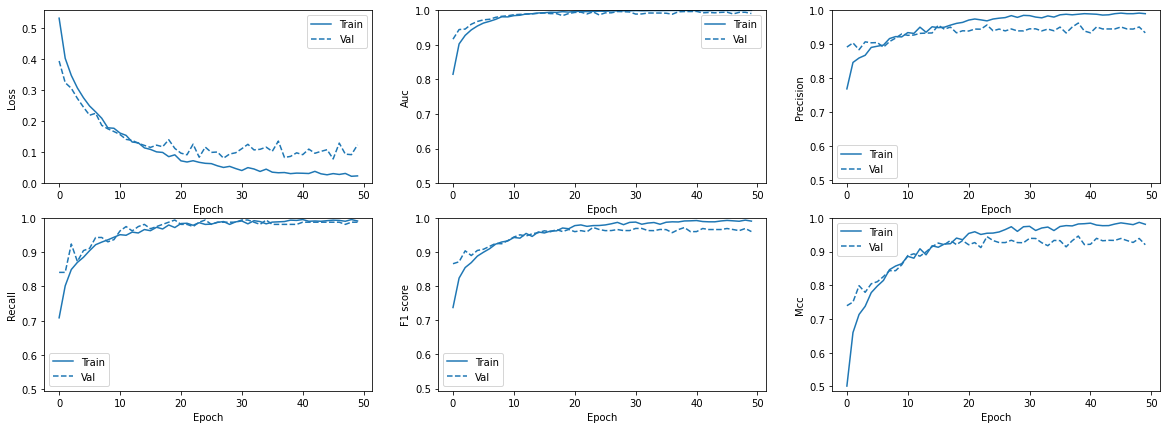

In [ ]:
if _RETRAIN_CNNs:
    lncRNA_training_history = lncRNA_CNN.fit(lncRNA_train, lncRNA_train_labels, batch_size=_BATCH_SIZE,
                                            epochs=_EPOCHS, validation_data=(lncRNA_val, lncRNA_val_labels),
                                            verbose=_VERBOSE, callbacks=get_callbacks('lncRNA_CNN'))
    plot_metrics(lncRNA_training_history, 'lncRNA_CNN')

Doing the same for the DNA data.

In [ ]:
if _RETRAIN_CNNs:
    DNA_CNN = models.Sequential(
        [
        layers.Conv1D(20, 8, strides=1, activation='relu', input_shape=(90, 1), name='conv_1'),
        layers.Conv1D(20, 4, strides=1, activation='relu', name='conv_2'),
        layers.Flatten(name='flatten'),
        layers.Dropout(0.5, name='dropout_1'),
        layers.Dense(600, activation='relu', name='dense_1'),
        layers.Dropout(0.5, name='dropout_2'),
        layers.Dense(1, activation='sigmoid', name='dense_2')
    ], name='DNA_CNN')

    DNA_CNN.compile(optimizer=optimizers.Adam(lr=_LEARNING_RATE), 
                    loss=losses.BinaryCrossentropy(),
                    metrics=_METRICS)

    DNA_CNN.summary()

Model: "DNA_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv1D)              (None, 83, 20)            180       
_________________________________________________________________
conv_2 (Conv1D)              (None, 80, 20)            1620      
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 600)               960600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 600)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 601 

Epoch 1/50
300/300 [==============================] - 11s 27ms/step - loss: 0.5628 - accuracy: 0.7504 - precision: 0.7353 - recall: 0.7913 - auc: 0.8268 - f1_score: 0.7621 - mcc: 0.4525 - val_loss: 0.4528 - val_accuracy: 0.7950 - val_precision: 0.7898 - val_recall: 0.8030 - val_auc: 0.8734 - val_f1_score: 0.7964 - val_mcc: 0.5928

Epoch 00001: val_loss improved from inf to 0.45279, saving model to ./models/DNA_CNN.h5
Epoch 2/50
300/300 [==============================] - 6s 19ms/step - loss: 0.4554 - accuracy: 0.7845 - precision: 0.7830 - recall: 0.7863 - auc: 0.8688 - f1_score: 0.7846 - mcc: 0.5729 - val_loss: 0.4356 - val_accuracy: 0.8058 - val_precision: 0.7933 - val_recall: 0.8264 - val_auc: 0.8833 - val_f1_score: 0.8095 - val_mcc: 0.6154

Epoch 00002: val_loss improved from 0.45279 to 0.43556, saving model to ./models/DNA_CNN.h5
Epoch 3/50
300/300 [==============================] - 5s 16ms/step - loss: 0.4391 - accuracy: 0.7968 - precision: 0.7971 - recall: 0.7964 - auc: 0.8771 - f

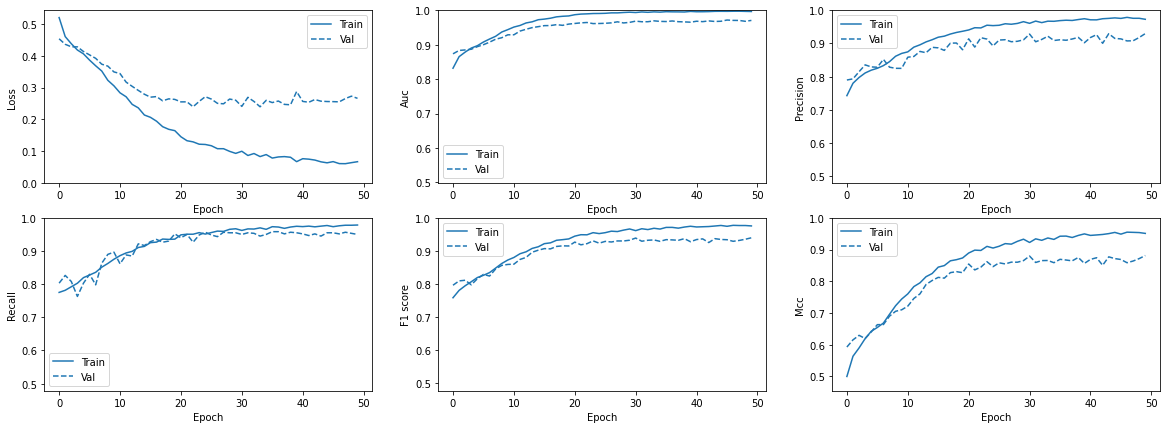

In [ ]:
if _RETRAIN_CNNs:
    DNA_training_history = DNA_CNN.fit(DNA_train, DNA_train_labels, batch_size=_BATCH_SIZE,
                                        epochs=_EPOCHS, validation_data=(DNA_val, DNA_val_labels),
                                        verbose=_VERBOSE, callbacks=get_callbacks('DNA_CNN'))
    plot_metrics(DNA_training_history, 'DNA_CNN')

Now we can test the models on the test set.

In [ ]:
if not _RETRAIN_CNNs:
    lncRNA_CNN = load_model('models/lncRNA_CNN.h5', custom_objects = {'f1_score': tfa.metrics.F1Score(name='f1_score', num_classes=1, threshold=0.5),
      'mcc': mcc})
    lncRNA_CNN.compile(optimizer=optimizers.Adam(lr=_LEARNING_RATE),
                    loss=losses.BinaryCrossentropy(),
                    metrics=_METRICS)
    lncRNA_CNN.summary()

Model: "lncRNA_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv1D)              (None, 83, 20)            180       
_________________________________________________________________
conv_2 (Conv1D)              (None, 82, 20)            820       
_________________________________________________________________
flatten (Flatten)            (None, 1640)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1640)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               656400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 4

In [ ]:
test_evals = lncRNA_CNN.evaluate(lncRNA_test, lncRNA_test_labels, verbose=_VERBOSE)
for metrics_name, metrics_value in zip(lncRNA_CNN.metrics_names, test_evals):
    print(f'Test {metrics_name}: {metrics_value}')     

10/10 [==============================] - 0s 13ms/step - loss: 0.1388 - accuracy: 0.9700 - precision: 0.9530 - recall: 0.9861 - auc: 0.9898 - f1_score: 0.9693 - mcc: 0.9449
Test loss: 0.1388108879327774
Test accuracy: 0.9700000286102295
Test precision: 0.9530201554298401
Test recall: 0.9861111044883728
Test auc: 0.989761471748352
Test f1_score: [0.9692833]
Test mcc: 0.9448833465576172


In [ ]:
if not _RETRAIN_CNNs:
    DNA_CNN = load_model('models/DNA_CNN.h5', custom_objects = {'f1_score': tfa.metrics.F1Score(name='f1_score', num_classes=1, threshold=0.5),
      'mcc': mcc})
    DNA_CNN.compile(optimizer=optimizers.Adam(lr=_LEARNING_RATE), 
                    loss=losses.BinaryCrossentropy(),
                    metrics=_METRICS)
    DNA_CNN.summary()

Model: "DNA_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv1D)              (None, 83, 20)            180       
_________________________________________________________________
conv_2 (Conv1D)              (None, 80, 20)            1620      
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 600)               960600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 600)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 601 

In [ ]:
test_evals = DNA_CNN.evaluate(DNA_test, DNA_test_labels, verbose=_VERBOSE)
for metrics_name, metrics_value in zip(DNA_CNN.metrics_names, test_evals):
    print(f'Test {metrics_name}: {metrics_value}')

38/38 [==============================] - 1s 12ms/step - loss: 0.2194 - accuracy: 0.9358 - precision: 0.9244 - recall: 0.9504 - auc: 0.9755 - f1_score: 0.9372 - mcc: 0.8749
Test loss: 0.21937891840934753
Test accuracy: 0.9358333349227905
Test precision: 0.9244372844696045
Test recall: 0.9504132270812988
Test auc: 0.9754734039306641
Test f1_score: [0.9372453]
Test mcc: 0.8749185800552368


If you want to check the random samples from the input data set, use this cell.

In [ ]:
# Generate a random index 0 <= random_sample_index <= 3000
random_sample_index = np.random.randint(_DATA_SIZE_lncRNA)

# Get the features - fetch them from lncRNA_features, expand the row to the matrix,
# then scale the matrix, then add additional axis to pass as an input to NN
random_sample_features = np.expand_dims(lncRNA_features[random_sample_index], axis=0)
random_sample_features_scaled = lncRNA_scaler.transform(random_sample_features)
random_sample_features_scaled = np.expand_dims(random_sample_features_scaled, axis=2)

# Fetch the label for the random sample and the sequence of this sample
random_sample_label = lncRNA_labels[random_sample_index]
random_sample_seq = lncRNA_seq[random_sample_index]

# Get prediction from the NN
random_sample_prediction = lncRNA_CNN.predict(random_sample_features_scaled)

print(f'Fetched a random sample with index={random_sample_index}')
print(f'The sequence of this sample is {random_sample_seq}')
print(f'The known label for the sample is {random_sample_label}')
print(f'The prediction of the NN is {random_sample_prediction[0][0]}')

Fetched a random sample with index=860
The sequence of this sample is GGCAGTTGCCGGACGCCATGTTGGTGAAGCGCCGGGGCTGCTAATGCTCCCTCCCCTCTTCCTCTTTGGCTCTCTCTCTCTCTTTTTCCAGACACCTTAAGGAATTCAACAACCCCTCCCCTGCACACAGGCTTCTTCCAGCCAGATGCCATGTTGCAAGATTTCCTCTGGAGAGGGCCTCTTGGCAAGGAACTGATGTCTCTGGCCAGCAGCCAGCGAGGACCTAAGATCTGTCAACAGCCATGCTTATGGCTGGTCTAGCAGAGCCAGGTGCCAGGCCTGGCGGGAGCATCCTTGTCTCTTAACTGACAGTGCCTCCACCTGGCCTTGCAGCTCCACTCGACAAATACTAAATAACAGGCTCTGGCATCTCCTGAAGCTCTGCACTCATTAACACACTGGGAGGTGTAGCTGTCAAGCTCTTCTCCAGGGGAGTTTTCTAAGAGCCTGGAAAACTGCCAGCCTCATCTGCCACTTCCCCTCTTCCCTGCACACACTCTCTGGCCACTAGCAACTCCACCCCGTTCTATTTAGCCCCCAGATCTCACTGCTTGCTCTTCTGTCATTCTGCAATGCCAGTACCTTCCTCTTCACCTGGCAAACTCCTATCCATCCTTCAGGTCCTGATCAAATGACCCCTCCTCCAGGAAGCCTTTCTCTAGATTTCCAAACACAGTGACTATTTTGTCCTGTAGTTTCCACTGATTGACAACCATCTTTCTGTTCTAGTTTCAGCTTCCCTGCACTATTGTTAACTATGTATCTGTTTCCTTCCACCTACCAAGCTGTATGTACCTTGAATAAATGGTCAAGGCGATTT
The known label for the sample is 0
The prediction of the NN is 2.8696756970703063e-08


## Training and testing ResNN

Now we will try other models which may improve the current performance. We will start by using residual networks. 

In [ ]:
if _RETRAIN_ResNNs:
    inputs = keras.Input(shape=(90, 1), name='input')
    x = layers.Conv1D(20, 8, activation='relu', name='conv_1')(inputs)
    x = layers.Dropout(0.5, name='dropout_1')(x)
    x = layers.Conv1D(40, 8, activation='relu', name='conv_2')(x)
    block_1_output = layers.MaxPooling1D(3, name='maxpool')(x)

    x = layers.Conv1D(40, 8, activation='relu', padding='same', name='conv_3')(block_1_output)
    x = layers.Dropout(0.5, name='dropout_2')(x)
    x = layers.Conv1D(40, 8, activation='relu', padding='same', name='conv_4')(x)
    block_2_output = layers.add([x, block_1_output])

    x = layers.Conv1D(20, 8, activation='relu', name='conv_5')(block_2_output)
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(50, activation='relu', name='dense_1')(x)
    x = layers.Dropout(0.5, name='dropout_3')(x)
    outputs = layers.Dense(1, activation='sigmoid', name='dense_2')(x)

    lncRNA_ResNN = keras.Model(inputs, outputs, name='lncRNA_ResNN')

    lncRNA_ResNN.compile(optimizer=optimizers.Adam(lr=_LEARNING_RATE), 
                        loss=losses.BinaryCrossentropy(),
                        metrics=_METRICS)

    lncRNA_ResNN.summary()

Model: "lncRNA_ResNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 90, 1)]      0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 83, 20)       180         input[0][0]                      
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 83, 20)       0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 76, 40)       6440        dropout_1[0][0]                  
_______________________________________________________________________________________

Epoch 1/50
75/75 [==============================] - 5s 35ms/step - loss: 0.6412 - accuracy: 0.8104 - precision: 0.7986 - recall: 0.8362 - auc: 0.8964 - f1_score: 0.8169 - mcc: 0.3045 - val_loss: 0.5290 - val_accuracy: 0.7700 - val_precision: 0.8099 - val_recall: 0.7325 - val_auc: 0.8336 - val_f1_score: 0.7692 - val_mcc: 0.5576

Epoch 00001: val_loss improved from inf to 0.52904, saving model to ./models/lncRNA_ResNN.h5
Epoch 2/50
75/75 [==============================] - 2s 22ms/step - loss: 0.5827 - accuracy: 0.7234 - precision: 0.7616 - recall: 0.6570 - auc: 0.7756 - f1_score: 0.7052 - mcc: 0.4566 - val_loss: 0.5129 - val_accuracy: 0.7833 - val_precision: 0.8333 - val_recall: 0.7325 - val_auc: 0.8761 - val_f1_score: 0.7797 - val_mcc: 0.5882

Epoch 00002: val_loss improved from 0.52904 to 0.51291, saving model to ./models/lncRNA_ResNN.h5
Epoch 3/50
75/75 [==============================] - 2s 21ms/step - loss: 0.5656 - accuracy: 0.7174 - precision: 0.7409 - recall: 0.6290 - auc: 0.7812 

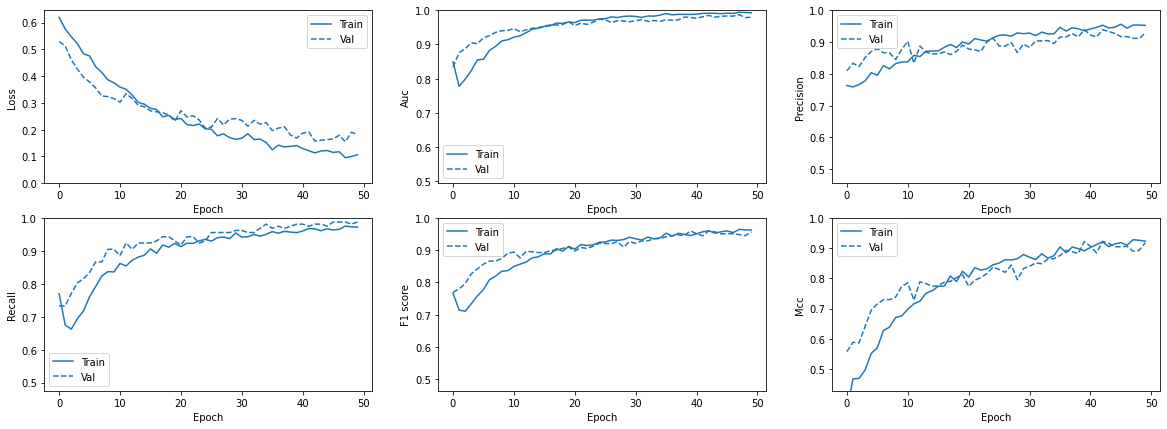

In [ ]:
if _RETRAIN_ResNNs:
    lncRNA_training_history = lncRNA_ResNN.fit(lncRNA_train, lncRNA_train_labels, batch_size=_BATCH_SIZE,
                                            epochs=_EPOCHS, validation_data=(lncRNA_val, lncRNA_val_labels),
                                            verbose=_VERBOSE, callbacks=get_callbacks('lncRNA_ResNN'))
    plot_metrics(lncRNA_training_history, 'lncRNA_ResNN')

In [ ]:
if _RETRAIN_ResNNs:
    inputs = keras.Input(shape=(90, 1), name='input')
    x = layers.Conv1D(20, 4, activation='relu', name='conv_1')(inputs)
    x = layers.Dropout(0.5, name='dropout_1')(x)
    x = layers.Conv1D(40, 4, activation='relu', name='conv_2')(x)
    block_1_output = layers.MaxPooling1D(3, name='maxpool')(x)

    x = layers.Conv1D(40, 4, activation='relu', padding='same', name='conv_3')(block_1_output)
    x = layers.Dropout(0.5, name='dropout_2')(x)
    x = layers.Conv1D(40, 4, activation='relu', padding='same', name='conv_4')(x)
    block_2_output = layers.add([x, block_1_output])

    x = layers.Conv1D(40, 4, activation='relu', name='conv_5')(block_2_output)
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(50, activation='relu', name='dense_1')(x)
    x = layers.Dropout(0.5, name='dropout_3')(x)
    outputs = layers.Dense(1, activation='sigmoid', name='dense_2')(x)

    DNA_ResNN = keras.Model(inputs, outputs, name="DNA_ResNN")

    DNA_ResNN.compile(optimizer=optimizers.Adam(lr=_LEARNING_RATE), 
                    loss=losses.BinaryCrossentropy(),
                    metrics=_METRICS)

    DNA_ResNN.summary()

Model: "DNA_ResNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 90, 1)]      0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 87, 20)       100         input[0][0]                      
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 87, 20)       0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 84, 40)       3240        dropout_1[0][0]                  
__________________________________________________________________________________________

Epoch 1/50
300/300 [==============================] - 11s 23ms/step - loss: 0.6152 - accuracy: 0.6892 - precision: 0.6684 - recall: 0.7569 - auc: 0.7579 - f1_score: 0.7093 - mcc: 0.3177 - val_loss: 0.5273 - val_accuracy: 0.7458 - val_precision: 0.7805 - val_recall: 0.6828 - val_auc: 0.8230 - val_f1_score: 0.7284 - val_mcc: 0.4988

Epoch 00001: val_loss improved from inf to 0.52730, saving model to ./models/DNA_ResNN.h5
Epoch 2/50
300/300 [==============================] - 6s 19ms/step - loss: 0.5276 - accuracy: 0.7376 - precision: 0.7316 - recall: 0.7484 - auc: 0.8161 - f1_score: 0.7391 - mcc: 0.4818 - val_loss: 0.4782 - val_accuracy: 0.7658 - val_precision: 0.7607 - val_recall: 0.7746 - val_auc: 0.8549 - val_f1_score: 0.7676 - val_mcc: 0.5326

Epoch 00002: val_loss improved from 0.52730 to 0.47815, saving model to ./models/DNA_ResNN.h5
Epoch 3/50
300/300 [==============================] - 5s 18ms/step - loss: 0.5074 - accuracy: 0.7585 - precision: 0.7585 - recall: 0.7531 - auc: 0.8329

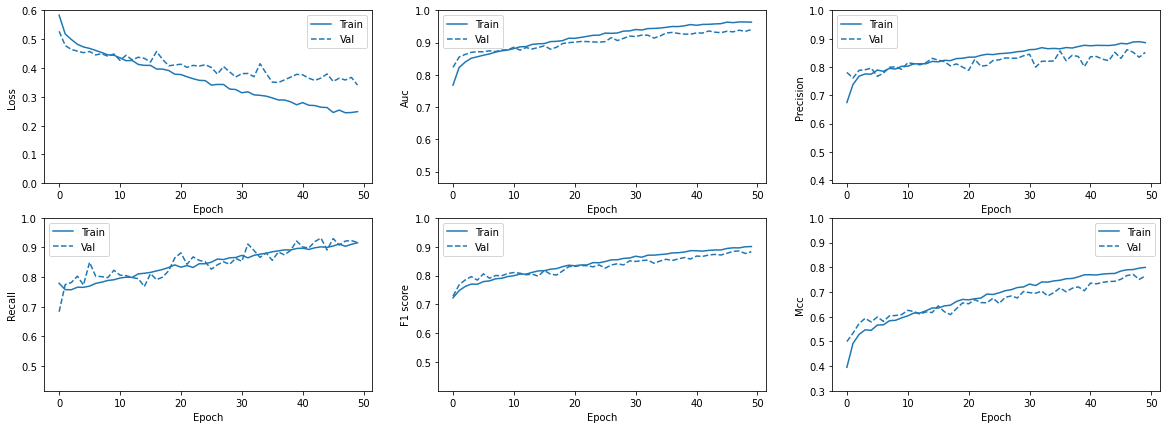

In [ ]:
if _RETRAIN_ResNNs:
    DNA_training_history = DNA_ResNN.fit(DNA_train, DNA_train_labels, batch_size=_BATCH_SIZE,
                                        epochs=_EPOCHS, validation_data=(DNA_val, DNA_val_labels),
                                        verbose=_VERBOSE, callbacks=get_callbacks('DNA_ResNN'))
    plot_metrics(DNA_training_history, 'DNA_ResNN')

Now we can test the residual models on the test set.

In [ ]:
if not _RETRAIN_ResNNs:
    lncRNA_ResNN = load_model('models/lncRNA_ResNN.h5', custom_objects = {'f1_score': tfa.metrics.F1Score(name='f1_score', num_classes=1, threshold=0.5),
      'mcc': mcc})
    lncRNA_ResNN.compile(optimizer=optimizers.Adam(lr=_LEARNING_RATE), 
                    loss=losses.BinaryCrossentropy(),
                    metrics=_METRICS)
    lncRNA_ResNN.summary()

Model: "lncRNA_ResNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 90, 1)]      0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 83, 20)       180         input[0][0]                      
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 83, 20)       0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 76, 40)       6440        dropout_1[0][0]                  
_______________________________________________________________________________________

In [ ]:
test_evals = lncRNA_ResNN.evaluate(lncRNA_test, lncRNA_test_labels, verbose=_VERBOSE)
for metrics_name, metrics_value in zip(lncRNA_ResNN.metrics_names, test_evals):
    print(f'Test {metrics_name}: {metrics_value}')

10/10 [==============================] - 0s 11ms/step - loss: 0.2001 - accuracy: 0.9333 - precision: 0.8924 - recall: 0.9792 - auc: 0.9830 - f1_score: 0.9338 - mcc: 0.8797
Test loss: 0.2001175433397293
Test accuracy: 0.9333333373069763
Test precision: 0.892405092716217
Test recall: 0.9791666865348816
Test auc: 0.9830173254013062
Test f1_score: [0.9337748]
Test mcc: 0.8797296285629272


In [ ]:
if not _RETRAIN_ResNNs:
    DNA_ResNN = load_model('models/DNA_ResNN.h5', custom_objects = {'f1_score': tfa.metrics.F1Score(name='f1_score', num_classes=1, threshold=0.5),
      'mcc': mcc})
    DNA_ResNN.compile(optimizer=optimizers.Adam(lr=_LEARNING_RATE), 
                    loss=losses.BinaryCrossentropy(),
                    metrics=_METRICS)

In [ ]:
DNA_ResNN.summary()
test_evals = DNA_ResNN.evaluate(DNA_test, DNA_test_labels, verbose=_VERBOSE)
for metrics_name, metrics_value in zip(DNA_ResNN.metrics_names, test_evals):
    print(f'Test {metrics_name}: {metrics_value}')

Model: "DNA_ResNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 90, 1)]      0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 87, 20)       100         input[0][0]                      
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 87, 20)       0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 84, 40)       3240        dropout_1[0][0]                  
__________________________________________________________________________________________

## Training and testing RecNNs

Let us now try Recurrent Neural Networks (RNNs). This kind of architecture works with variable-length data which should be perfect for our case as we work with nucleotide sequence data. The main idea for this model is that we iterate over the input sequence, and by remembering each step try to predict the desired value - predicted class. For this project we will be using LSTM architecture, that uses different mechanisms to keep relevant information for prediction, while forgetting the information that is irrelevant. Moreover, we will use bidirectional LSTM model, that scans the sequence in both directions - that way we will remember both the "past" and the "future" of the sequence.

To process lncRNA and DNA sequences in the NNs we will have two different representations. 

In the first case we will transform nucleotide sequence data to one-hot view. For example, the sequence AGGCT would be the matrix:

$$
\begin{matrix}
\mathrm{A}\\
\mathrm{G}\\
\mathrm{G}\\
\mathrm{C}\\
\mathrm{T}\\
\end{matrix}
\begin{pmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1\\
\end{pmatrix}
$$

In the second case we will divide each nucleotide sequence in small subsequences called k-mers, tokenize them (assume they are like words in the sentence), and source them to the NN. For example, if we have the same sequence AGGCT and we are using 3-mers, we will have AGG, GGC, GCT 3-mers. After tokenization we will map each 3-mer to an integer value - {'AGG': 1, 'GGC': 2, 'GCT': 3}, and eventually will obtain the following column representation of nucleotide sequence:

$$
\begin{matrix}
\mathrm{AGG}\\
\mathrm{GGC}\\
\mathrm{GCT}\\
\end{matrix}
\begin{pmatrix}
1\\
2\\
3\\
\end{pmatrix}
$$

Another concern to consider is whether we put all sequences with their full-length, or cut them in subsequences (e.g. size of 1000 nucleotides) and source them into the NN. The issue with the first method is that we will need to find a way to process variable-length sequences in one batch, while the issue with the second method is that the subsequences of smaller size may lose long-distance interactions with nucleotides. 

If we use the first method we need to eacb sequence with -1 value at the end - thus all sequences will have the length of the longest nucleotide sequence, but the majority will have -1 at the end. Then we use masking to ignore these padded steps during training and testing. For more info look [here](https://datascience.stackexchange.com/questions/48796/how-to-feed-lstm-with-different-input-array-sizes) and [here](https://www.tensorflow.org/guide/keras/masking_and_padding).

The second method does not need any additional preprocessing. For now, we will drop this method and look if previous one works.

In [ ]:
def seq2onehot(seq):
    nuc2onehot = {'A': [1, 0, 0, 0],
                  'G': [0, 1, 0, 0],
                  'C': [0, 0, 1, 0],
                  'T': [0, 0, 0, 1]}
    out_matrix = []
    for nuc in seq:
        out_matrix.append(nuc2onehot[nuc])
  
    return out_matrix

def get_kmers_from_seq(seq, k=10):
    return [str(seq[i:i+k]) for i in range(len(seq) - k + 1)]
        
lncRNA_onehot = list(map(seq2onehot, lncRNA_seq))
DNA_onehot = list(map(seq2onehot, DNA_seq))
lncRNA_kmer = [' '.join(get_kmers_from_seq(seq)) for seq in lncRNA_seq]
DNA_kmer = [' '.join(get_kmers_from_seq(seq)) for seq in DNA_seq]

Let us understand how much vary the lncRNA and DNA sequences.

In [ ]:
# Let's understand the threshold for clipping very long sequences
print(f'The median length of DNA samples: {np.median(DNA_lengths)}. The median length of lncRNA samples: {np.median(lncRNA_lengths)}.')
print(f'The range for lncRNA length: {(np.min(lncRNA_lengths), np.max(lncRNA_lengths))}. The range for DNA length: {(np.min(DNA_lengths), np.max(DNA_lengths))}.')

print(f'\nTotal number of lncRNA sequences: {len(lncRNA_lengths)}')
lncRNA_thresholds = [200000, 100000, 50000, 10000, 7500, 2500]
for threshold in lncRNA_thresholds:
    print(f'Number of lncRNA sequences that have length > {threshold}: {np.sum(np.array(lncRNA_lengths) > threshold)}') 

print(f'\nTotal number of DNA sequences: {len(DNA_lengths)}')
DNA_thresholds = [3500, 3000, 2500, 2300, 2000, 1500]
for threshold in DNA_thresholds:
    print(f'Number of DNA sequences that have length > {threshold}: {np.sum(np.array(DNA_lengths) > threshold)}')

The median length of DNA samples: 601.0. The median length of lncRNA samples: 1181.0.
The range for lncRNA length: (79, 205012). The range for DNA length: (151, 3851).

Total number of lncRNA sequences: 36553
Number of lncRNA sequences that have length > 200000: 1
Number of lncRNA sequences that have length > 100000: 1
Number of lncRNA sequences that have length > 50000: 2
Number of lncRNA sequences that have length > 10000: 58
Number of lncRNA sequences that have length > 7500: 174
Number of lncRNA sequences that have length > 2500: 5360

Total number of DNA sequences: 15282
Number of DNA sequences that have length > 3500: 6
Number of DNA sequences that have length > 3000: 42
Number of DNA sequences that have length > 2500: 66
Number of DNA sequences that have length > 2300: 96
Number of DNA sequences that have length > 2000: 210
Number of DNA sequences that have length > 1500: 798


Now we will be able to either tokenize the sequences (if we deal with k-mer representation), or just pad them (if you have one-hot representation).

It should be noticed that tokenization fitting should be done only on training data. The maximum possible length of the sequence should be also extracted solely from training data.

In [ ]:
def calc_max_length(data, data_type):
    # Calculate the maximum sequence length in data
    # data_type = 'onehot' -> the data has one-hot matrix format
    # data_type = 'kmer' -> the data has sequence kmers format
    return max(len(t) for t in data) if data_type == 'onehot' else \
        max(len(t.split(' ')) for t in data) if data_type == 'kmer' else -1

# Splitting data into train, validation and test as 80%/10%/10% (denoted in the cell above)
lncRNA_onehot_train = lncRNA_onehot[:_lncRNA_TRAIN_SIZE]
lncRNA_onehot_test = lncRNA_onehot[_lncRNA_TRAIN_SIZE:]
lncRNA_onehot_val = lncRNA_onehot_test[:_lncRNA_VAL_SIZE]
lncRNA_onehot_test = lncRNA_onehot_test[_lncRNA_TEST_SIZE:]

lncRNA_kmer_train = lncRNA_kmer[:_lncRNA_TRAIN_SIZE]
lncRNA_kmer_test = lncRNA_kmer[_lncRNA_TRAIN_SIZE:]
lncRNA_kmer_val = lncRNA_kmer_test[:_lncRNA_VAL_SIZE]
lncRNA_kmer_test = lncRNA_kmer_test[_lncRNA_TEST_SIZE:]

DNA_onehot_train = DNA_onehot[:_DNA_TRAIN_SIZE]
DNA_onehot_test = DNA_onehot[_DNA_TRAIN_SIZE:]
DNA_onehot_val = DNA_onehot_test[:_DNA_VAL_SIZE]
DNA_onehot_test = DNA_onehot_test[_DNA_TEST_SIZE:]

DNA_kmer_train = DNA_kmer[:_DNA_TRAIN_SIZE]
DNA_kmer_test = DNA_kmer[_DNA_TRAIN_SIZE:]
DNA_kmer_val = DNA_kmer_test[:_DNA_VAL_SIZE]
DNA_kmer_test = DNA_kmer_test[_DNA_TEST_SIZE:]

########
##  The first method - the data is represented as one-hot matrix
########

# Defining the maximum possible sequence length based on training data
_MAX_LEN_onehot_lncRNA = calc_max_length(lncRNA_onehot_train, data_type='onehot')
_MAX_LEN_onehot_DNA = calc_max_length(DNA_onehot_train, data_type='onehot')

# Pad the sequences with -1 to be able to mask them after
lncRNA_onehot_train = pad_sequences(lncRNA_onehot_train, maxlen=_MAX_LEN_onehot_lncRNA, 
                                    truncating='post', padding='post', value=-1)
lncRNA_onehot_val = pad_sequences(lncRNA_onehot_val, maxlen=_MAX_LEN_onehot_lncRNA, 
                                  truncating='post', padding='post', value=-1)
lncRNA_onehot_test = pad_sequences(lncRNA_onehot_test, maxlen=_MAX_LEN_onehot_lncRNA, 
                                   truncating='post', padding='post', value=-1)

DNA_onehot_train = pad_sequences(DNA_onehot_train, maxlen=_MAX_LEN_onehot_DNA, 
                                 truncating='post', padding='post', value=-1)
DNA_onehot_val = pad_sequences(DNA_onehot_val, maxlen=_MAX_LEN_onehot_DNA, 
                               truncating='post', padding='post', value=-1)
DNA_onehot_test = pad_sequences(DNA_onehot_test, maxlen=_MAX_LEN_onehot_DNA, 
                                truncating='post', padding='post', value=-1)

########
##  The second method - the data is represented as a sequence of k-mers
########

# Defining the maximum possible sequence length based on training data
_MAX_LEN_kmer_lncRNA = calc_max_length(lncRNA_kmer_train, data_type='kmer')
_MAX_LEN_kmer_DNA = calc_max_length(DNA_kmer_train, data_type='kmer')

# lncRNA...
tokenizer = Tokenizer(oov_token="<unk>")
tokenizer.fit_on_texts(lncRNA_kmer_train)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
_VOCAB_SIZE_lncRNA = len(tokenizer.index_word)

lncRNA_kmer_tokend_train = tokenizer.texts_to_sequences(lncRNA_kmer_train)
lncRNA_kmer_tokend_val = tokenizer.texts_to_sequences(lncRNA_kmer_val)
lncRNA_kmer_tokend_test = tokenizer.texts_to_sequences(lncRNA_kmer_test)

lncRNA_kmer_input_train = pad_sequences(lncRNA_kmer_tokend_train, truncating='post', padding='post', maxlen=_MAX_LEN_kmer_lncRNA)
lncRNA_kmer_input_val = pad_sequences(lncRNA_kmer_tokend_val, truncating='post', padding='post', maxlen=_MAX_LEN_kmer_lncRNA)
lncRNA_kmer_input_test = pad_sequences(lncRNA_kmer_tokend_test, truncating='post', padding='post', maxlen=_MAX_LEN_kmer_lncRNA)

# DNA...
tokenizer = Tokenizer(oov_token="<unk>")
tokenizer.fit_on_texts(DNA_kmer_train)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
_VOCAB_SIZE_DNA = len(tokenizer.index_word)

DNA_kmertok_train = tokenizer.texts_to_sequences(DNA_kmer_train)
DNA_kmertok_val = tokenizer.texts_to_sequences(DNA_kmer_val)
DNA_kmertok_test = tokenizer.texts_to_sequences(DNA_kmer_test)

DNA_kmer_input_train = pad_sequences(DNA_kmertok_train, truncating='post', padding='post', maxlen=_MAX_LEN_kmer_DNA)
DNA_kmer_input_val = pad_sequences(DNA_kmertok_val, truncating='post', padding='post', maxlen=_MAX_LEN_kmer_DNA)
DNA_kmer_input_test = pad_sequences(DNA_kmertok_test, truncating='post', padding='post', maxlen=_MAX_LEN_kmer_DNA)

Okay, now the data is ready!

Let us now look at the NN architecture we will use to build a model. In the following cell we will implement a `keras.layers.Layer` class which will implement the time-step average layer. Basically, after we will apply Bidirectional LSTM, we will get a matrix of shape (n_steps, n_features), and after applying `TimeStepsAverage`, we will get a matrix of shape (n_features) - the matrix is averaged along the time-step axis. It is the same layer that is used in [this](https://www.tandfonline.com/doi/full/10.1080/15476286.2018.1551704) paper.

We again additionally set some hyperparameters of training.

In [ ]:
_BATCH_SIZE_RecNN = 16
_EPOCHS_RecNN = 80
_LEARNING_RATE_RecNN = 1e-3

class TimeStepsAverage(keras.layers.Layer):
    def __init__(self, **kwargs):
        self.supports_masking = True
        super(TimeStepsAverage, self).__init__(**kwargs)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        if mask is not None:
            # mask (batch, time)
            mask = K.cast(mask, tf.float32)
            # mask (batch, x_dim, time)
            mask = K.repeat(mask, x.shape[-1])
            # mask (batch, time, x_dim)
            mask = tf.transpose(mask, perm=[0,2,1])
            x = x * mask
        return K.sum(x, axis=1) / K.sum(mask, axis=1)

    def get_output_shape_for(self, input_shape):
        # remove temporal dimension
        return input_shape[0], input_shape[2]

Let us summarize everything:

1. The model with `TimeStepsAverage` layer after bidirectional LSTM layer. We save all LSTM outputs from the entire sequence and average them. This model is a replica from [this](https://www.tandfonline.com/doi/full/10.1080/15476286.2018.1551704) paper. The input data here is one-hot encoded. The variable-length sequences are padded, and corresponding steps are masked (left out durring training).
2. The model where we save only the last output of the LSTM, and then apply Dense layers to make prediction. The input data here is one-hot encoded. The variable-length sequences are padded, and corresponding steps are masked (left out durring training).
3. The model where the input is k-mer encoded. Prior to bidirectional LSTM we have Embedding layer that maps each obtained k-mer to a vector of length 10. This model has the most number of parameters thus we also use dropout to generalize the model. The variable-length sequences are padded, and corresponding steps are masked (left out durring training).

We apply the same 3 architecture for lncRNA data and for DNA data.

In [ ]:
if _RETRAIN_RecNNs:
    lncRNA_LSTM_1 = models.Sequential(
        [
         layers.Input(shape=(None, 4)),
         layers.Masking(mask_value=-1),  # for only one-hot matrix
         layers.Bidirectional(layers.LSTM(45, return_sequences=True), name='bidirectional'),
         TimeStepsAverage(name='time_average'),
         layers.Dense(100, name='dense_1', activation='relu'),
         layers.Dense(30, name='dense_2', activation='relu'),
         layers.Dense(1, name='dense_3', activation='sigmoid')
      ], name='lncRNA_LSTM_1')

    lncRNA_LSTM_1.compile(optimizer=optimizers.RMSprop(lr=_LEARNING_RATE_RecNN), 
                          loss=losses.BinaryCrossentropy(),
                          metrics=_METRICS)

    lncRNA_LSTM_1.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "lncRNA_LSTM_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, None, 4)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 90)          18000     
_______________________________________________

In [ ]:
if _RETRAIN_RecNNs:
    lncRNA_training_history = lncRNA_LSTM_1.fit(lncRNA_onehot_train, lncRNA_train_labels,
                                                batch_size=_BATCH_SIZE_RecNN,
                                                validation_data=(lncRNA_onehot_val, lncRNA_val_labels),
                                                epochs=_EPOCHS_RecNN, verbose=_VERBOSE, 
                                                callbacks=get_callbacks('lncRNA_LSTM_1', with_early_stopping=False)
                                                )
    plot_metrics(lncRNA_training_history, 'lncRNA_LSTM_1')

Epoch 1/80
150/150 [==============================] - 160s 948ms/step - loss: 0.6544 - accuracy: 0.6249 - precision: 0.6347 - recall: 0.5677 - auc: 0.6641 - f1_score: 0.5970 - mcc: nan - val_loss: 0.5532 - val_accuracy: 0.7467 - val_precision: 0.7956 - val_recall: 0.6943 - val_auc: 0.7988 - val_f1_score: 0.7415 - val_mcc: 0.5065

Epoch 00001: val_loss improved from inf to 0.55315, saving model to ./models/lncRNA_LSTM_1.h5
Epoch 2/80
150/150 [==============================] - 138s 924ms/step - loss: 0.5901 - accuracy: 0.7013 - precision: 0.7146 - recall: 0.6460 - auc: 0.7449 - f1_score: 0.6784 - mcc: 0.4223 - val_loss: 0.5753 - val_accuracy: 0.7267 - val_precision: 0.8319 - val_recall: 0.5987 - val_auc: 0.8027 - val_f1_score: 0.6963 - val_mcc: 0.4906

Epoch 00002: val_loss did not improve from 0.55315
Epoch 3/80
150/150 [==============================] - 121s 809ms/step - loss: 0.6043 - accuracy: 0.6969 - precision: 0.7159 - recall: 0.6606 - auc: 0.7279 - f1_score: 0.6868 - mcc: 0.4139 

In [ ]:
if not _RETRAIN_RecNNs:
    lncRNA_LSTM_1 = load_model('models/lncRNA_LSTM_1.h5', custom_objects = {'f1_score': tfa.metrics.F1Score(name='f1_score', num_classes=1, threshold=0.5),
      'mcc': mcc, 'TimeStepsAverage': TimeStepsAverage})
    lncRNA_LSTM_1.compile(optimizer=optimizers.RMSprop(lr=_LEARNING_RATE_RecNN), 
                          loss=losses.BinaryCrossentropy(),
                          metrics=_METRICS)
    lncRNA_LSTM_1.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "lncRNA_LSTM_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, None, 4)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 90)          18000     
_______________________________________________

In [ ]:
test_evals = lncRNA_LSTM_1.evaluate(lncRNA_onehot_test, lncRNA_test_labels, verbose=_VERBOSE)
for metrics_name, metrics_value in zip(lncRNA_LSTM_1.metrics_names, test_evals):
    print(f'Test {metrics_name}: {metrics_value}')

10/10 [==============================] - 4s 391ms/step - loss: 0.4991 - accuracy: 0.7867 - precision: 0.7532 - recall: 0.8264 - auc: 0.8498 - f1_score: 0.7881 - mcc: 0.5799
Test loss: 0.49913355708122253
Test accuracy: 0.7866666913032532
Test precision: 0.753164529800415
Test recall: 0.8263888955116272
Test auc: 0.8498263359069824
Test f1_score: [0.78807944]
Test mcc: 0.579892098903656


In [ ]:
if _RETRAIN_RecNNs:
    lncRNA_LSTM_2 = models.Sequential(
        [
         layers.Input(shape=(None, 4)),
         layers.Masking(mask_value=-1),
         layers.Bidirectional(layers.LSTM(45), name='bidirectional'),
         layers.Dense(100, name='dense_1', activation='relu'),
         layers.Dense(30, name='dense_2', activation='relu'),
         layers.Dense(1, name='dense_3', activation='sigmoid')
      ], name='lncRNA_LSTM_2')

    lncRNA_LSTM_2.compile(optimizer=optimizers.Adam(lr=_LEARNING_RATE_RecNN), 
                          loss=losses.BinaryCrossentropy(),
                          metrics=_METRICS)

    lncRNA_LSTM_2.summary()

Model: "lncRNA_LSTM_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, None, 4)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 90)                18000     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               9100      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 30,161
Trainable params: 30,161
Non-trainable params: 0
_________________________________________________________________


In [ ]:
if _RETRAIN_RecNNs:
    lncRNA_training_history = lncRNA_LSTM_2.fit(lncRNA_onehot_train, lncRNA_train_labels,
                                                batch_size=_BATCH_SIZE_RecNN,
                                                validation_data=(lncRNA_onehot_val, lncRNA_val_labels),
                                                epochs=_EPOCHS_RecNN, verbose=_VERBOSE,
                                                callbacks=get_callbacks('lncRNA_LSTM_2', with_early_stopping=False)
                                                )
    plot_metrics(lncRNA_training_history, 'lncRNA_LSTM_2')

Epoch 1/80
150/150 [==============================] - 120s 700ms/step - loss: 0.5702 - accuracy: 0.7035 - precision: 0.7029 - recall: 0.7276 - auc: 0.7735 - f1_score: 0.7141 - mcc: 0.4142 - val_loss: 0.5269 - val_accuracy: 0.7467 - val_precision: 0.8293 - val_recall: 0.6497 - val_auc: 0.8304 - val_f1_score: 0.7286 - val_mcc: 0.5069

Epoch 00001: val_loss improved from inf to 0.52695, saving model to ./models/lncRNA_LSTM_2.h5
Epoch 2/80
150/150 [==============================] - 98s 654ms/step - loss: 0.5754 - accuracy: 0.6938 - precision: 0.7179 - recall: 0.6449 - auc: 0.7669 - f1_score: 0.6786 - mcc: nan - val_loss: 0.5201 - val_accuracy: 0.7567 - val_precision: 0.8182 - val_recall: 0.6879 - val_auc: 0.8240 - val_f1_score: 0.7474 - val_mcc: 0.5236

Epoch 00002: val_loss improved from 0.52695 to 0.52011, saving model to ./models/lncRNA_LSTM_2.h5
Epoch 3/80
150/150 [==============================] - 96s 644ms/step - loss: 0.5579 - accuracy: 0.7154 - precision: 0.7322 - recall: 0.6765 - 

In [ ]:
if not _RETRAIN_RecNNs:
    lncRNA_LSTM_2 = load_model('models/lncRNA_LSTM_2.h5', custom_objects = {'f1_score': tfa.metrics.F1Score(name='f1_score', num_classes=1, threshold=0.5),
      'mcc': mcc})
    lncRNA_LSTM_2.compile(optimizer=optimizers.Adam(lr=_LEARNING_RATE_RecNN), 
                          loss=losses.BinaryCrossentropy(),
                          metrics=_METRICS)
    lncRNA_LSTM_2.summary()

Model: "lncRNA_LSTM_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, None, 4)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 90)                18000     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               9100      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 30,161
Trainable params: 30,161
Non-trainable params: 0
_________________________________________________________________


In [ ]:
test_evals = lncRNA_LSTM_2.evaluate(lncRNA_onehot_test, lncRNA_test_labels, verbose=_VERBOSE)
for metrics_name, metrics_value in zip(lncRNA_LSTM_2.metrics_names, test_evals):
    print(f'Test {metrics_name}: {metrics_value}')

10/10 [==============================] - 4s 362ms/step - loss: 0.5691 - accuracy: 0.7067 - precision: 0.6918 - recall: 0.7014 - auc: 0.7638 - f1_score: 0.6966 - mcc: 0.4096
Test loss: 0.5691353678703308
Test accuracy: 0.7066666483879089
Test precision: 0.6917808055877686
Test recall: 0.7013888955116272
Test auc: 0.76384437084198
Test f1_score: [0.69655174]
Test mcc: 0.4095904231071472


In [ ]:
if _RETRAIN_RecNNs:
    lncRNA_LSTM_3 = models.Sequential(
        [   
         layers.Embedding(_VOCAB_SIZE_lncRNA, 10, name='embedding', mask_zero=True),
         layers.Bidirectional(layers.LSTM(45, dropout=0.5), name='bidirectional'),
         layers.Dense(10, activation='relu', name='dense_1'),
         layers.Dropout(0.5),
         layers.Dense(1, activation='sigmoid', name='dense_2')
      ], name='lncRNA_LSTM_3')

    lncRNA_LSTM_3.compile(optimizer=optimizers.RMSprop(lr=_LEARNING_RATE_RecNN), 
                          loss=losses.BinaryCrossentropy(),
                          metrics=_METRICS)

    lncRNA_LSTM_3.summary()

Model: "lncRNA_LSTM_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 10)          6727980   
_________________________________________________________________
bidirectional (Bidirectional (None, 90)                20160     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                910       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 6,749,061
Trainable params: 6,749,061
Non-trainable params: 0
_________________________________________________________________


In [ ]:
if _RETRAIN_RecNNs:
    lncRNA_training_history = lncRNA_LSTM_3.fit(lncRNA_kmer_input_train, lncRNA_train_labels,
                                                batch_size=_BATCH_SIZE_RecNN,
                                                validation_data=(lncRNA_kmer_input_val, lncRNA_val_labels),
                                                epochs=_EPOCHS_RecNN, verbose=_VERBOSE, 
                                                callbacks=get_callbacks('lncRNA_LSTM_3')
                                                )
    plot_metrics(lncRNA_training_history, 'lncRNA_LSTM_3')

Epoch 1/80
150/150 [==============================] - 129s 768ms/step - loss: 0.6837 - accuracy: 0.5923 - precision: 0.5991 - recall: 0.4787 - auc: 0.6263 - f1_score: 0.5303 - mcc: nan - val_loss: 0.4905 - val_accuracy: 0.8133 - val_precision: 0.8855 - val_recall: 0.7389 - val_auc: 0.9319 - val_f1_score: 0.8056 - val_mcc: 0.6434

Epoch 00001: val_loss improved from inf to 0.49053, saving model to ./models/lncRNA_LSTM_3.h5
Epoch 2/80
150/150 [==============================] - 112s 747ms/step - loss: 0.3738 - accuracy: 0.8779 - precision: 0.8881 - recall: 0.8614 - auc: 0.9313 - f1_score: 0.8743 - mcc: nan - val_loss: 0.1240 - val_accuracy: 0.9767 - val_precision: 0.9934 - val_recall: 0.9618 - val_auc: 0.9889 - val_f1_score: 0.9773 - val_mcc: 0.9546

Epoch 00002: val_loss improved from 0.49053 to 0.12401, saving model to ./models/lncRNA_LSTM_3.h5
Epoch 3/80
150/150 [==============================] - 112s 751ms/step - loss: 0.1149 - accuracy: 0.9769 - precision: 0.9834 - recall: 0.9705 - a

In [ ]:
if not _RETRAIN_RecNNs:
    lncRNA_LSTM_3 = load_model('models/lncRNA_LSTM_3.h5', custom_objects = {'f1_score': tfa.metrics.F1Score(name='f1_score', num_classes=1, threshold=0.5),
      'mcc': mcc})
    lncRNA_LSTM_3.compile(optimizer=optimizers.RMSprop(lr=_LEARNING_RATE_RecNN), 
                          loss=losses.BinaryCrossentropy(),
                          metrics=_METRICS)
    lncRNA_LSTM_3.summary()

Model: "lncRNA_LSTM_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 10)          6727980   
_________________________________________________________________
bidirectional (Bidirectional (None, 90)                20160     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                910       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 6,749,061
Trainable params: 6,749,061
Non-trainable params: 0
_________________________________________________________________


In [ ]:
test_evals = lncRNA_LSTM_3.evaluate(lncRNA_kmer_input_test, lncRNA_test_labels, verbose=_VERBOSE)
for metrics_name, metrics_value in zip(lncRNA_LSTM_3.metrics_names, test_evals):
    print(f'Test {metrics_name}: {metrics_value}')

10/10 [==============================] - 4s 384ms/step - loss: 0.0572 - accuracy: 0.9867 - precision: 0.9930 - recall: 0.9792 - auc: 0.9937 - f1_score: 0.9860 - mcc: 0.9746
Test loss: 0.057194359600543976
Test accuracy: 0.9866666793823242
Test precision: 0.9929577708244324
Test recall: 0.9791666865348816
Test auc: 0.9936566352844238
Test f1_score: [0.986014]
Test mcc: 0.9745966196060181


We try the same architecture with DNA..

In [ ]:
if _RETRAIN_RecNNs:
    DNA_LSTM_1 = models.Sequential(
        [
         layers.Input(shape=(None, 4)),
         layers.Masking(mask_value=-1),  # for only one-hot matrix
         layers.Bidirectional(layers.LSTM(45, return_sequences=True), name='bidirectional'),
         TimeStepsAverage(name='time_average'),
         layers.Dense(100, name='dense_1', activation='relu'),
         layers.Dense(30, name='dense_2', activation='relu'),
         layers.Dense(1, name='dense_3', activation='sigmoid')
      ], name='DNA_LSTM_1')

    DNA_LSTM_1.compile(optimizer=optimizers.RMSprop(lr=_LEARNING_RATE_RecNN), 
                          loss=losses.BinaryCrossentropy(),
                          metrics=_METRICS)

    DNA_LSTM_1.summary()

Model: "DNA_LSTM_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_2 (Masking)          (None, None, 4)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 90)          18000     
_________________________________________________________________
time_average (TimeStepsAvera (None, 90)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               9100      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 30,161
Trainable params: 30,161
Non-trainable params: 0
____________________________________________________

In [ ]:
if _RETRAIN_RecNNs:
    DNA_training_history = DNA_LSTM_1.fit(DNA_onehot_train, DNA_train_labels,
                                                batch_size=_BATCH_SIZE_RecNN,
                                                validation_data=(DNA_onehot_val, DNA_val_labels),
                                                epochs=_EPOCHS_RecNN, verbose=_VERBOSE, 
                                                callbacks=get_callbacks('DNA_LSTM_1', with_early_stopping=False)
                                                )
    plot_metrics(DNA_training_history, 'DNA_LSTM_1')

Epoch 1/80
600/600 [==============================] - 141s 221ms/step - loss: 0.6494 - accuracy: 0.6697 - precision: 0.6386 - recall: 0.8039 - auc: 0.7183 - f1_score: 0.7113 - mcc: nan - val_loss: 0.6136 - val_accuracy: 0.6758 - val_precision: 0.6162 - val_recall: 0.9299 - val_auc: 0.6961 - val_f1_score: 0.7412 - val_mcc: 0.4046

Epoch 00001: val_loss improved from inf to 0.61359, saving model to ./models/DNA_LSTM_1.h5
Epoch 2/80
600/600 [==============================] - 131s 218ms/step - loss: 0.6206 - accuracy: 0.6649 - precision: 0.6244 - recall: 0.8592 - auc: 0.6722 - f1_score: 0.7231 - mcc: nan - val_loss: 0.6344 - val_accuracy: 0.6208 - val_precision: 0.6469 - val_recall: 0.5292 - val_auc: 0.7125 - val_f1_score: 0.5822 - val_mcc: 0.2423

Epoch 00002: val_loss did not improve from 0.61359
Epoch 3/80
600/600 [==============================] - 128s 214ms/step - loss: 0.6246 - accuracy: 0.6563 - precision: 0.6194 - recall: 0.8088 - auc: 0.6929 - f1_score: 0.7010 - mcc: nan - val_los

In [ ]:
if not _RETRAIN_RecNNs:
    DNA_LSTM_1 = load_model('models/DNA_LSTM_1.h5', custom_objects = {'f1_score': tfa.metrics.F1Score(name='f1_score', num_classes=1, threshold=0.5),
      'mcc': mcc, 'TimeStepsAverage': TimeStepsAverage})
    DNA_LSTM_1.compile(optimizer=optimizers.RMSprop(lr=_LEARNING_RATE_RecNN), 
                          loss=losses.BinaryCrossentropy(),
                          metrics=_METRICS)
    DNA_LSTM_1.summary()

Model: "DNA_LSTM_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_2 (Masking)          (None, None, 4)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 90)          18000     
_________________________________________________________________
time_average (TimeStepsAvera (None, 90)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               9100      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 30,161
Trainable params: 30,161
Non-trainable params: 0
____________________________________________________

In [ ]:
test_evals = DNA_LSTM_1.evaluate(DNA_onehot_test, DNA_test_labels, verbose=_VERBOSE)
for metrics_name, metrics_value in zip(DNA_LSTM_1.metrics_names, test_evals):
    print(f'Test {metrics_name}: {metrics_value}')

38/38 [==============================] - 17s 149ms/step - loss: 0.3463 - accuracy: 0.8581 - precision: 0.8458 - recall: 0.8681 - auc: 0.9241 - f1_score: 0.8567 - mcc: 0.7196
Test loss: 0.3749501407146454
Test accuracy: 0.8358333110809326
Test precision: 0.8322475552558899
Test recall: 0.844628095626831
Test auc: 0.9115493893623352
Test f1_score: [0.8383922]
Test mcc: 0.6770308017730713


In [ ]:
if _RETRAIN_RecNNs:
    DNA_LSTM_2 = models.Sequential(
        [
         layers.Input(shape=(None, 4)),
         layers.Masking(mask_value=-1),
         layers.Bidirectional(layers.LSTM(45), name='bidirectional'),
         layers.Dense(100, name='dense_1', activation='relu'),
         layers.Dense(30, name='dense_2', activation='relu'),
         layers.Dense(1, name='dense_3', activation='sigmoid')
      ], name='DNA_LSTM_2')

    DNA_LSTM_2.compile(optimizer=optimizers.Adam(lr=_LEARNING_RATE_RecNN), 
                          loss=losses.BinaryCrossentropy(),
                          metrics=_METRICS)

    DNA_LSTM_2.summary()

Model: "DNA_LSTM_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, None, 4)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 90)                18000     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               9100      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 30,161
Trainable params: 30,161
Non-trainable params: 0
_________________________________________________________________


In [ ]:
if _RETRAIN_RecNNs:
    DNA_training_history = DNA_LSTM_2.fit(DNA_onehot_train, DNA_train_labels,
                                                batch_size=_BATCH_SIZE_RecNN,
                                                validation_data=(DNA_onehot_val, DNA_val_labels),
                                                epochs=_EPOCHS_RecNN, verbose=_VERBOSE,
                                                callbacks=get_callbacks('DNA_LSTM_2', with_early_stopping=False)
                                                )
    plot_metrics(DNA_training_history, 'DNA_LSTM_2')

Epoch 1/80
600/600 [==============================] - 146s 227ms/step - loss: 0.6762 - accuracy: 0.6454 - precision: 0.6326 - recall: 0.7209 - auc: 0.7107 - f1_score: 0.6727 - mcc: nan - val_loss: 0.6712 - val_accuracy: 0.5675 - val_precision: 0.5373 - val_recall: 0.9616 - val_auc: 0.6000 - val_f1_score: 0.6894 - val_mcc: nan

Epoch 00001: val_loss improved from inf to 0.67120, saving model to ./models/DNA_LSTM_2.h5
Epoch 2/80
600/600 [==============================] - 130s 217ms/step - loss: 0.6750 - accuracy: 0.5520 - precision: 0.5268 - recall: 0.8934 - auc: 0.5673 - f1_score: 0.6613 - mcc: nan - val_loss: 0.6759 - val_accuracy: 0.5683 - val_precision: 0.5709 - val_recall: 0.5442 - val_auc: 0.6067 - val_f1_score: 0.5573 - val_mcc: 0.1396

Epoch 00002: val_loss did not improve from 0.67120
Epoch 3/80
600/600 [==============================] - 130s 216ms/step - loss: 0.6758 - accuracy: 0.5679 - precision: 0.5509 - recall: 0.7549 - auc: 0.5844 - f1_score: 0.6366 - mcc: nan - val_loss: 

In [ ]:
if not _RETRAIN_RecNNs:
    DNA_LSTM_2 = load_model('models/DNA_LSTM_2.h5', custom_objects = {'f1_score': tfa.metrics.F1Score(name='f1_score', num_classes=1, threshold=0.5),
      'mcc': mcc})
    DNA_LSTM_2.compile(optimizer=optimizers.Adam(lr=_LEARNING_RATE_RecNN), 
                          loss=losses.BinaryCrossentropy(),
                          metrics=_METRICS)
    DNA_LSTM_2.summary()

Model: "DNA_LSTM_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, None, 4)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 90)                18000     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               9100      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 30,161
Trainable params: 30,161
Non-trainable params: 0
_________________________________________________________________


In [ ]:
test_evals = DNA_LSTM_2.evaluate(DNA_onehot_test, DNA_test_labels, verbose=_VERBOSE)
for metrics_name, metrics_value in zip(DNA_LSTM_2.metrics_names, test_evals):
    print(f'Test {metrics_name}: {metrics_value}')

38/38 [==============================] - 10s 133ms/step - loss: 0.6319 - accuracy: 0.6567 - precision: 0.6265 - recall: 0.7901 - auc: 0.6847 - f1_score: 0.6988 - mcc: 0.3261
Test loss: 0.6319050192832947
Test accuracy: 0.6566666960716248
Test precision: 0.6264744400978088
Test recall: 0.7900826334953308
Test auc: 0.6846767663955688
Test f1_score: [0.69883037]
Test mcc: 0.3260866403579712


In [ ]:
if _RETRAIN_RecNNs:
    DNA_LSTM_3 = models.Sequential(
        [

         layers.Embedding(_VOCAB_SIZE_DNA, 10, name='embedding', mask_zero=True),
         layers.Bidirectional(layers.LSTM(45, dropout=0.5), name='bidirectional'),
         layers.Dense(10, activation='relu', name='dense_1'),
         layers.Dropout(0.5),
         layers.Dense(1, activation='sigmoid', name='dense_2')
      ], name='DNA_LSTM_3')

    DNA_LSTM_3.compile(optimizer=optimizers.RMSprop(lr=_LEARNING_RATE_RecNN), 
                          loss=losses.BinaryCrossentropy(),
                          metrics=_METRICS)

    DNA_LSTM_3.summary()

Model: "DNA_LSTM_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 10)          8440420   
_________________________________________________________________
bidirectional (Bidirectional (None, 90)                20160     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                910       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 8,461,501
Trainable params: 8,461,501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
if _RETRAIN_RecNNs:
    DNA_training_history = DNA_LSTM_3.fit(DNA_kmer_input_train, DNA_train_labels,
                                                batch_size=_BATCH_SIZE_RecNN,
                                                validation_data=(DNA_kmer_input_val, DNA_val_labels),
                                                epochs=_EPOCHS_RecNN, verbose=_VERBOSE, 
                                                callbacks=get_callbacks('DNA_LSTM_3')
                                                )
    plot_metrics(DNA_training_history, 'DNA_LSTM_3')

Epoch 1/80
600/600 [==============================] - 212s 333ms/step - loss: 0.6848 - accuracy: 0.5769 - precision: 0.5797 - recall: 0.5688 - auc: 0.6172 - f1_score: 0.5704 - mcc: nan - val_loss: 0.5193 - val_accuracy: 0.7275 - val_precision: 0.8636 - val_recall: 0.5392 - val_auc: 0.8945 - val_f1_score: 0.6639 - val_mcc: 0.4863

Epoch 00001: val_loss improved from inf to 0.51932, saving model to ./models/DNA_LSTM_3.h5
Epoch 2/80
600/600 [==============================] - 196s 327ms/step - loss: 0.3870 - accuracy: 0.8580 - precision: 0.8557 - recall: 0.8573 - auc: 0.9107 - f1_score: 0.8563 - mcc: 0.7224 - val_loss: 0.3074 - val_accuracy: 0.9000 - val_precision: 0.9012 - val_recall: 0.8982 - val_auc: 0.9479 - val_f1_score: 0.8997 - val_mcc: 0.8000

Epoch 00002: val_loss improved from 0.51932 to 0.30739, saving model to ./models/DNA_LSTM_3.h5
Epoch 3/80
600/600 [==============================] - 208s 346ms/step - loss: 0.1507 - accuracy: 0.9570 - precision: 0.9600 - recall: 0.9535 - auc:

In [ ]:
if not _RETRAIN_RecNNs:
    DNA_LSTM_3 = load_model('models/DNA_LSTM_3.h5', custom_objects = {'f1_score': tfa.metrics.F1Score(name='f1_score', num_classes=1, threshold=0.5),
      'mcc': mcc})
    DNA_LSTM_3.compile(optimizer=optimizers.RMSprop(lr=_LEARNING_RATE_RecNN), 
                          loss=losses.BinaryCrossentropy(),
                          metrics=_METRICS)
    DNA_LSTM_3.summary()

Model: "DNA_LSTM_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 10)          8440420   
_________________________________________________________________
bidirectional (Bidirectional (None, 90)                20160     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                910       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 8,461,501
Trainable params: 8,461,501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
test_evals = DNA_LSTM_3.evaluate(DNA_kmer_input_test, DNA_test_labels, verbose=_VERBOSE)
for metrics_name, metrics_value in zip(DNA_LSTM_3.metrics_names, test_evals):
    print(f'Test {metrics_name}: {metrics_value}')

38/38 [==============================] - 12s 135ms/step - loss: 0.1974 - accuracy: 0.9250 - precision: 0.9511 - recall: 0.8922 - auc: 0.9769 - f1_score: 0.9202 - mcc: 0.8541
Test loss: 0.23854731023311615
Test accuracy: 0.9233333468437195
Test precision: 0.9539822936058044
Test recall: 0.8909090757369995
Test auc: 0.966993510723114
Test f1_score: [0.9213676]
Test mcc: 0.8498991131782532


## Performance comparison of different models

Let us make a quick plot that will visualize the difference in performance between the trained models. Based on a bootstrap test statistics we will compute the 95 % confidence interval of the performance metric for each model.

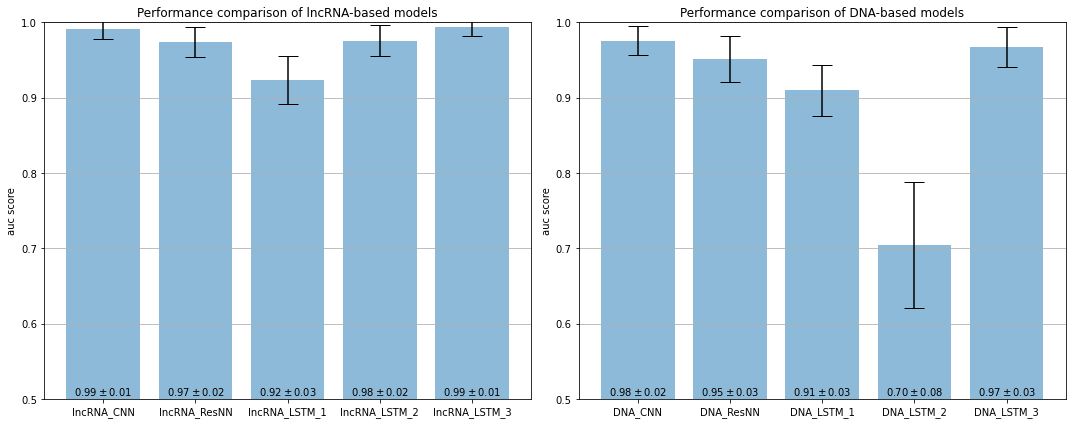

In [ ]:
# Choose the metric to plot
metric_to_plot = 'auc'  # possible options are: accuracy, precision, recall, auc, f1_score, mcc
_BOOTSTRAP_N = 50
_SAMPLES_PER_BOOTSTRAP = 200

def get_bootstrap_statistics(model, test_data, test_labels, metrics, 
                             n_bootstraps, n_samples):
    # This function evaluates the model performance based on bootstrap 
    # statistics
    evals = []
    for _ in range(n_bootstraps):
        sub_data, sub_target = resample(test_data, test_labels, n_samples=n_samples)
        sub_eval = model.evaluate(sub_data, sub_target, verbose=0)
        evals.append(sub_eval[model.metrics_names.index(metrics)])

    return np.mean(evals), np.std(evals) * 2

lncRNA_models = {'lncRNA_CNN': ('kmer_score', lncRNA_CNN), 'lncRNA_ResNN': ('kmer_score', lncRNA_ResNN),
                 'lncRNA_LSTM_1': ('onehot', lncRNA_LSTM_1), 'lncRNA_LSTM_2': ('onehot', lncRNA_LSTM_2),
                 'lncRNA_LSTM_3': ('kmer', lncRNA_LSTM_3)}
DNA_models = {'DNA_CNN': ('kmer_score', DNA_CNN), 'DNA_ResNN': ('kmer_score', DNA_ResNN), 
              'DNA_LSTM_1': ('onehot', DNA_LSTM_1), 'DNA_LSTM_2': ('onehot', DNA_LSTM_2),
              'DNA_LSTM_3': ('kmer', DNA_LSTM_3)}
lncRNA_metrics = {}
DNA_metrics = {}

# Computing the metric lncRNA models
for model_name, (input_type, model) in lncRNA_models.items():
    test_labels = lncRNA_test_labels
    if input_type == 'kmer_score':
        test_data = lncRNA_test
    elif input_type == 'onehot':
        test_data = lncRNA_onehot_test
    elif input_type == 'kmer':
        test_data = lncRNA_kmer_input_test
    lncRNA_metrics[model_name] = get_bootstrap_statistics(
        model, test_data, test_labels, metric_to_plot, _BOOTSTRAP_N, 
        _SAMPLES_PER_BOOTSTRAP
    )
    
# Computing the metric DNA models
for model_name, (input_type, model) in DNA_models.items():
    test_labels = DNA_test_labels
    if input_type == 'kmer_score':
        test_data = DNA_test
    elif input_type == 'onehot':
        test_data = DNA_onehot_test
    elif input_type == 'kmer':
        test_data = DNA_kmer_input_test
    DNA_metrics[model_name] = get_bootstrap_statistics(
        model, test_data, test_labels, metric_to_plot, _BOOTSTRAP_N, 
        _SAMPLES_PER_BOOTSTRAP
    )

f, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].bar(range(len(lncRNA_metrics)), 
          [mean for model_name, (mean, _) in lncRNA_metrics.items()], 
          yerr=[err for model_name, (_, err) in lncRNA_metrics.items()], 
          align='center', alpha=0.5, ecolor='black', capsize=10)
ax[0].set_ylabel(f'{metric_to_plot} score')
ax[0].set_xticks(range(len(lncRNA_metrics)))
ax[0].set_xticklabels([model_name for model_name, _ in lncRNA_metrics.items()])
ax[0].set_title('Performance comparison of lncRNA-based models')
ax[0].yaxis.grid(True)
ax[0].set_ylim([0.5, 1])

# Make some labels.
for bar, (mean, std) in zip(ax[0].patches, lncRNA_metrics.values()):
    ax[0].annotate(fr'${mean:.2f} \pm {std:.2f}$', 
                   (bar.get_x() + bar.get_width() / 2, 
                    0.5), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

ax[1].bar(range(len(DNA_metrics)), 
          [mean for model_name, (mean, _) in DNA_metrics.items()], 
          yerr=[err for model_name, (_, err) in DNA_metrics.items()], 
          align='center', alpha=0.5, ecolor='black', capsize=10)
ax[1].set_ylabel(f'{metric_to_plot} score')
ax[1].set_xticks(range(len(lncRNA_metrics)))
ax[1].set_xticklabels([model_name for model_name, _ in DNA_metrics.items()])
ax[1].set_title('Performance comparison of DNA-based models')
ax[1].yaxis.grid(True)
ax[1].set_ylim([0.5, 1])

# Make some labels.
for bar, (mean, std) in zip(ax[1].patches, DNA_metrics.values()):
    ax[1].annotate(fr'${mean:.2f} \pm {std:.2f}$', 
                   (bar.get_x() + bar.get_width() / 2, 
                    0.5), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

# Save the figure and show
plt.tight_layout()

plt.savefig('./figs/model_comparison.png', dpi=300)